In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import datapackage
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import statsmodels.api as sm
import statsmodels.tsa.vector_ar.vecm as vecm
import statsmodels.formula.api as smf
import statsmodels.tsa.stattools as ts

## testing armington elastcities UK gas market ##

url = 'https://raw.githubusercontent.com/joe-ascroft/phd/master/data/CPI_CCCI_test.csv'
df = pd.read_csv(url)
df["Date"] = pd.to_datetime(df["Date"],dayfirst=True)
for col in df.columns[1:]:
    df[col] = pd.to_numeric(df[col],errors='coerce')


df2 = df[(df['Date'] < '2021-3-1')]

In [2]:
print(df2)

         Date   CPI  CCCI  Maint  Serv
0  2013-12-01  1.10   0.8   0.73  1.62
1  2014-03-01  1.24   0.4  -0.32  1.52
2  2014-06-01  1.22   0.5   0.72 -0.15
3  2014-09-01  1.13   1.2   0.64  1.05
4  2014-12-01  1.72   0.6   0.16  0.22
5  2015-03-01  0.81   0.8  -0.24  0.74
6  2015-06-01  1.53   0.6   0.63  0.37
7  2015-09-01  1.36   1.0   0.39  0.44
8  2015-12-01  1.20   0.5   0.94  0.44
9  2016-03-01  0.84   0.8  -0.23  1.38
10 2016-06-01  2.08   0.3   1.64  0.64
11 2016-09-01  2.04   0.7   0.54  0.64
12 2016-12-01  1.40   0.9   0.08  0.71
13 2017-03-01  0.99   1.7   0.23  0.63
14 2017-06-01  1.82   1.9   0.76  0.77
15 2017-09-01  1.09   1.8   0.53  1.25
16 2017-12-01  1.30   1.1  -0.72  1.63
17 2018-03-01  0.39   1.1   0.30  1.55
18 2018-06-01  1.07   1.0   0.50  0.57
19 2018-09-01  1.25   1.1   1.09  0.57
20 2018-12-01  0.86   1.3   0.29  0.76
21 2019-03-01  0.66   1.3  -0.98  0.75
22 2019-06-01  0.66   0.6   1.39  0.56
23 2019-09-01  0.56   1.0   1.17  1.02
24 2019-12-01  0.46   0.9

                            OLS Regression Results                            
Dep. Variable:                   Serv   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     1.988
Date:                Sun, 16 Oct 2022   Prob (F-statistic):              0.170
Time:                        17:08:16   Log-Likelihood:                -15.465
No. Observations:                  29   AIC:                             34.93
Df Residuals:                      27   BIC:                             37.66
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5523      0.201      2.750      0.0

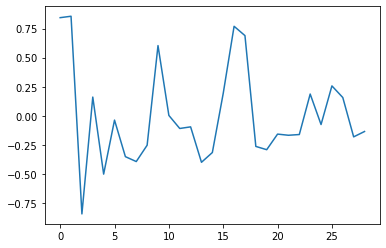

In [5]:
result1 = smf.ols(formula="Serv ~ CCCI", data=df2).fit()
print(result1.summary())
plt.plot(result1.resid)

In [ ]:
test = ts.adfuller(result1.resid,autolag="AIC")
print(test)

In [6]:
lag_order1 = vecm.select_order(data=df2[['CPI', 'CCCI']], maxlags=5, deterministic="ci")
print(lag_order1.selected_orders)

{'aic': 3, 'bic': 0, 'hqic': 0, 'fpe': 0}


In [13]:
m1 = vecm.VECM(df2[['CPI', 'CCCI']], deterministic="ci", k_ar_diff=1, coint_rank=1)  
vecm_res_1 = m1.fit()
vecm_res_1.summary()

,coef,std err,z,P>|z|,[0.025,0.975]
L1.CPI,-0.1116,0.186,-0.601,0.548,-0.476,0.253
L1.CCCI,0.6130,0.234,2.615,0.009,0.154,1.072
,coef,std err,z,P>|z|,[0.025,0.975]
L1.CPI,0.1989,0.165,1.202,0.229,-0.125,0.523
L1.CCCI,-0.1760,0.209,-0.843,0.399,-0.585,0.233
,coef,std err,z,P>|z|,[0.025,0.975]
ec1,-0.6039,0.180,-3.350,0.001,-0.957,-0.251
,coef,std err,z,P>|z|,[0.025,0.975]
ec1,-0.0245,0.161,-0.152,0.879,-0.339,0.290
,coef,std err,z,P>|z|,[0.025,0.975]


In [ ]:
granger_results = vecm_res_1.test_granger_causality(caused="Maint", signif=0.05)
granger_results.summary()